In [2]:
from typing import Optional, Tuple
from astropy.io import fits
from astropy.table import Table, vstack
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme(style="ticks")

In [3]:
# Open the FITS files
# Define the pattern to match FITS files
pattern = '../Disk_Lomeli/*.fits'

# Use glob to find all FITS files in the current directory
fits_files = glob.glob(pattern)

print(fits_files)

['../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_1_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_8_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_4_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_7_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_2_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_6_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_5_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_3_disco.fits', '../Disk_Lomeli/catalog_all_bands_all_fovs_all_sources_pueba_9_disco.fits']


In [4]:
# Create an empty list to store individual tables
tables = []    

In [5]:
# Loop through each FITS file and read it into a Table
for file in fits_files:
    with fits.open(file) as hdul:
        # Extract data from the FITS file
        data = hdul[1].data  # Assuming the data is in the first extension (HDU index 1)
        
        # Convert the data to a Table
        table = Table(data)
        
        # Append the Table to the list
        tables.append(table)

In [6]:
# Concatenate all Tables into a single Table
final_table_ = vstack(tables)
final_table_

NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,ierr,z,zerr,F378,F378err,F395,F395err,F410,F410err,F430,F430err,F515,F515err,F660,F660err,F861,F861err,flags_i,fwhm_i,fwhm_psf_i,ellog_i,ellip_i,class_i,spread_i,flux_radius_i,area_i,mumax_i,mag_aper2_i,magerr_apper2_i,mag_aper4_i,magerr_apper4_i,mag_aper6_i,magerr_apper6_i,flux_aper6_u,fluxerr_aper6_u,flux_aper6_g,fluxerr_aper6_g,flux_aper6_r,fluxerr_aper6_r,flux_aper6_i,fluxerr_aper6_i,flux_aper6_z,fluxerr_aper6_z,flux_aper6_F378,fluxerr_aper6_F378,flux_aper6_F395,fluxerr_aper6_F395,flux_aper6_F410,fluxerr_aper6_F410,flux_aper6_F430,fluxerr_aper6_F430,flux_aper6_F515,fluxerr_aper6_F515,flux_aper6_F660,fluxerr_aper6_F660,flux_aper6_F861,fluxerr_aper6_F861,x,y,field,a_image,b_image,theta_image,kron_radius_i,flags_r,fwhm_r,fwhm_psf_r,ellog_r,ellip_r,class_r,spread_r,flux_radius_r,area_r,mumax_r,kron_radius_r
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64
1,101.12644465695432,-10.612184907318111,14.702288,0.004686178,13.257763,0.0017844065,12.814565,0.0012317247,12.681818,0.001156154,12.62246,0.0013372924,14.220668,0.0053780703,14.091446,0.007090692,13.665978,0.0052532903,13.572099,0.0049138935,13.114592,0.0031770724,12.781118,0.0013998582,12.778827,0.0020322804,0,2.2154946,1.22,1.0917432,0.08403367,0.9992135,0.0014839264,1.4314586,361,13.693411,12.913642,0.0012113939,12.746799,0.001140913,12.6865225,0.0011385307,112.11451,0.5415721,4679.8765,7.9201665,7902.449,8.815167,7589.104,7.9561954,4712.7134,5.7346187,80.825,0.44474006,88.19591,0.63689476,322.38467,1.704378,379.37668,1.8469042,788.5272,2.3821447,821.38635,1.0508235,1602.5546,2.8045635,10044.566,841.9639,d020,1.9007711,1.7410424,23.145464,3.5,0,2.4987614,1.45,1.0917432,0.08403367,0.9959378,0.0035467616,1.5721868,360,13.946505,3.5
2,101.22978673763829,-10.613081022602527,14.67916,0.004649523,13.313589,0.0018312561,12.953415,0.0013162483,12.858995,0.0012567932,12.826505,0.0014716754,14.127555,0.0051233573,13.849711,0.0062634177,13.561735,0.0049898895,13.472548,0.004675302,13.155522,0.003237394,12.966757,0.0015296927,12.8338375,0.0020889763,0,2.1587255,1.22,1.0371287,0.035799503,0.94983697,0.001044648,1.386691,349,14.04207,13.089363,0.0013151255,12.929202,0.0012461123,12.873191,0.001251721,111.61028,0.54090804,4425.452,7.7496295,6838.537,8.274526,6390.3306,7.3654804,3879.7107,5.2650046,87.51147,0.4565131,108.82025,0.6829859,350.28885,1.7521025,406.06848,1.890666,758.4683,2.346031,688.99786,0.97238725,1344.9175,2.596336,9379.57,837.4964,d020,1.8212997,1.756098,5.855979,3.5,0,2.4132965,1.45,1.0371287,0.035799503,0.99576354,0.0030613788,1.5621964,348,14.25836,3.5
4,101.16174743658358,-10.61482234181521,17.98022,0.03374533,15.468643,0.0056189857,14.42472,0.0026955763,13.920295,0.002088307,13.616056,0.0021516453,17.408234,0.03340907,17.12144,0.040355034,16.436012,0.025632963,16.211199,0.021782702,15.269113,0.009635036,14.272796,0.0028832657,13.750359,0.0032428738,0,2.156533,1.22,1.1065474,0.096288085,0.9893148,0.00069352874,1.3745962,167,14.856633,14.148031,0.0021701485,13.988389,0.002119385,13.95061,0.0022397968,4.8737197,0.35804337,607.33264,4.454188,1772.8076,4.943882,2368.9492,4.885787,1839.001,3.8802238,4.730932,0.278123,4.3873477,0.39820844,23.769323,1.0694544,32.04664,1.1350572,107.52826,1.338808,203.93661,0.6030942,585.2536,1.8499994,9817.362,825.19977,d020,1.7553142,1.5862983,-2.66182,3.5,0,2.3990223,1.45,1.1065474,0.09628

In [7]:
# Define conditions for filtering the table
mask_fields = (final_table_["field"] == "d049") | \
              (final_table_["field"] == "d203") | \
              (final_table_["field"] == "d218") | \
              (final_table_["field"] == "d243") | \
              (final_table_["field"] == "d262")

final_table = final_table_[mask_fields]


In [8]:
len(final_table["field"])

300530

## Cleaning

In [9]:
# Masking, usar FLATS menor que 4
# Masking
# Define SNR threshold
snr_threshold = 5

# Calculate SNR for each band
snr_r = final_table["r"] / final_table["rerr"]
snr_F660 = final_table["F660"] / final_table["F660err"]
snr_i = final_table["i"] / final_table["ierr"]

# Masking for SNR
m_snr = (snr_r >= snr_threshold) & (snr_F660 >= snr_threshold) & (snr_i >= snr_threshold)

m_x =  (final_table["r"] >= 13) & (final_table["r"] <= 19.5) &\
       (final_table["F660"] <= 19.4) & (final_table["i"] <= 19.2) 

m_err = (final_table["rerr"] <= 0.2) & \
        (final_table["F660err"] <= 0.2) & \
        (final_table["ierr"] <= 0.2)


#m_sn = (tab["s2n_r_PStotal"] >= 10) & \
#       (tab["s2n_J0660_PStotal"] >= 10) & \
#        (tab["s2n_i_PStotal"] >= 10)

m_ell = (final_table["ellip_r"] <= 0.2) & (final_table["ellip_i"] <= 0.2)

m_50 = (final_table["flux_radius_r"] <= 3) & (final_table["flux_radius_i"] <= 3)

flags = (final_table["flags_r"] == 0) & (final_table["flags_i"] == 0)

class_star = (final_table["class_r"] > 0.5) & (final_table["class_i"] > 0.5)


mask = m_snr & m_x & m_err & m_ell & m_50 & flags & class_star # Use fwhm_mask instead of valid_fwhm_range
tab_clean = final_table[mask]

In [10]:
tab_clean

NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,ierr,z,zerr,F378,F378err,F395,F395err,F410,F410err,F430,F430err,F515,F515err,F660,F660err,F861,F861err,flags_i,fwhm_i,fwhm_psf_i,ellog_i,ellip_i,class_i,spread_i,flux_radius_i,area_i,mumax_i,mag_aper2_i,magerr_apper2_i,mag_aper4_i,magerr_apper4_i,mag_aper6_i,magerr_apper6_i,flux_aper6_u,fluxerr_aper6_u,flux_aper6_g,fluxerr_aper6_g,flux_aper6_r,fluxerr_aper6_r,flux_aper6_i,fluxerr_aper6_i,flux_aper6_z,fluxerr_aper6_z,flux_aper6_F378,fluxerr_aper6_F378,flux_aper6_F395,fluxerr_aper6_F395,flux_aper6_F410,fluxerr_aper6_F410,flux_aper6_F430,fluxerr_aper6_F430,flux_aper6_F515,fluxerr_aper6_F515,flux_aper6_F660,fluxerr_aper6_F660,flux_aper6_F861,fluxerr_aper6_F861,x,y,field,a_image,b_image,theta_image,kron_radius_i,flags_r,fwhm_r,fwhm_psf_r,ellog_r,ellip_r,class_r,spread_r,flux_radius_r,area_r,mumax_r,kron_radius_r
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64
6,103.9929687474367,-13.428945838897354,17.558426,0.037186403,16.457819,0.008627022,15.062158,0.0047498033,14.528512,0.0048987176,15.001179,0.004376651,17.572401,0.03645239,16.767115,0.04190851,17.00758,0.032177996,16.919367,0.027146399,15.595202,0.014346705,15.477065,0.0052239457,15.043343,0.006232808,0,2.2974868,1.42,1.1188537,0.10622811,0.99189615,0.0025447183,1.2613475,84,15.248842,14.749799,0.004925732,14.632338,0.005421871,14.607938,0.0064160875,4.5437813,0.40246797,298.934,4.4596987,674.45483,4.0553913,725.81323,4.288104,500.02072,2.6762693,4.1971316,0.30803797,5.385164,0.44072402,18.174911,1.1667006,23.979128,1.2231604,60.064354,1.3301616,72.42313,0.4799588,172.69493,1.2759746,8831.541,830.15283,d049,1.5507541,1.3860204,24.222027,3.5,0,2.34367,1.56,1.1188537,0.10622811,0.9833968,0.0012031794,1.3383524,91,15.730018,3.5
13,103.79418959544672,-13.428848998826895,19.624134,0.19525766,18.384398,0.029691592,16.619013,0.011358818,15.995865,0.010711718,16.404009,0.009347746,19.70005,0.18969686,99.0,99.0,19.32395,0.18417668,20.471495,0.42855293,17.445848,0.046933413,16.965809,0.012125123,16.34656,0.012393092,0,2.3747337,1.42,1.1176077,0.10523164,0.9828983,0.0011686183,1.2552923,44,16.81447,16.19355,0.011221845,16.065493,0.014780372,15.999137,0.019008351,0.5383735,0.39461324,18.233322,4.1134453,165.55067,3.4664655,201.53267,3.527444,130.39409,2.2054498,-0.17783247,0.2969604,2.828066,0.43193159,-2.375146,1.1193411,-6.6244264,1.1614524,6.1915226,1.2088614,20.471674,0.4097455,71.36422,1.089483,10097.306,827.5926,d049,1.4202284,1.2707754,23.357145,3.5,0,2.244436,1.56,1.1176077,0.10523164,0.98166734,0.0029519938,1.3014678,42,17.343012,3.5
22,104.09580027205325,-13.428032316113134,99.0,99.0,20.868046,0.24588208,18.7558,0.052600242,17.97419,0.03896879,18.257133,0.030850193,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,19.833729,0.3484885,19.011566,0.051800072,18.41069,0.0458306,0,2.0678816,1.42,1.1128101,0.10137415,0.96011406,-0.0027312248,1.0946764,13,18.881119,18.298277,0.053072065,18.288946,0.09723731,18.276285,0.14175762,-1.401747,0.39341155,-19.084814,4.088436,14.37829,3.2702658,24.74493,3.2300022,18.405767,2.0409367,-0.506151,0.29684365,-0.46871716,0.42201176,-1.156574,1.118901,1.6731938,1.1653775,-1.8555788,1.1937158,2.1740534,0.38185915,6.5083094,0.9509881,8176.782,837.3854,d049,1.205964,1.0837104,38.428295,3.5,0,2.2144997,1.56,1.1128101,0.10137415,0.9727788,-0.0036278774,1.1267222,15,19.69439,3.5
28,104.11413076860609,-13.428511530385

In [11]:
ri = tab_clean["r"] - tab_clean["i"]
rj660 = tab_clean["r"] - tab_clean["F660"]

In [12]:
def equation(m, c, x):
    # Define your equation here, for example, a linear equation: y = mx + c
    y = m * x + c
    return y

In [13]:
def plots(
    color1: np.ndarray,
    color2: np.ndarray,
    x_values: np.ndarray,
    y_values: np.ndarray,
    y_values1: Optional[np.ndarray] = None,
    sample_size: Optional[int] = None,
    xlim: Optional[Tuple[float, float]] = None,
    ylim: Optional[Tuple[float, float]] = None,
    density_method: str = "gaussian_kde",
    colormap: str = "viridis",
    label1: str = None,
    label2: str = None,
    label3: str = None,
    title: str = "Scatter Plot with Density Coloring"
) -> None:
    """
    Plots a scatter plot with points colored based on their density and one or two lines 
    defined by x_values, y_values, and optionally y_values1.
    """

    # Handle sampling and duplicate colors, ensuring equal lengths
    if sample_size is not None:
        unique_indices = np.random.choice(len(color1), size=sample_size, replace=False)
        color1, color2 = color1[unique_indices], color2[unique_indices]

    # Calculate density
    xy = np.vstack([color1, color2])
    if density_method == "gaussian_kde":
        density = gaussian_kde(xy)(xy)
    else:
        raise NotImplementedError(f"Density method {density_method} not supported.")

    # Sort points by density
    sorted_indices = density.argsort()[::-1]  # Descending order
    color1, color2, density = color1[sorted_indices], color2[sorted_indices], density[sorted_indices]

    # Create plot
    fig, ax = plt.subplots(figsize=(14, 11))

    # Customize scatter plot
    scatter_collection = ax.scatter(
        color1,
        color2,
        c=density,
        s=10,
        cmap=colormap,
        alpha=0.8,
        label=label1 if label1 else "Color 1"
    )

    # Customize colorbar
    plt.colorbar(scatter_collection, label="Density")

    # Customize line plots
    plt.plot(x_values, y_values, linewidth=2, color="red", label=label2 if label2 else "Line 1")
    if y_values1 is not None:
        plt.plot(x_values, y_values1, linewidth=2, color="blue", label=label3 if label3 else "Line 2")

    # Set limits
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Add labels and title
    plt.xlabel(label1 if label1 else "Color 1")
    plt.ylabel(label2 if label2 else "Color 2")
    plt.title(title)

    # Add legend if labels are provided
    if label1 or label2 or label3:
        plt.legend()

    plt.show()

In [14]:
# Generate x values
x_values = np.linspace(-10, 10, 100)  # Generate 100 x values from 0 to 10

# Compute y values using the equation
y_values = equation(0.35, -0.55, x_values)

In [15]:
y_values1 = equation(0.35, 0.45, x_values)

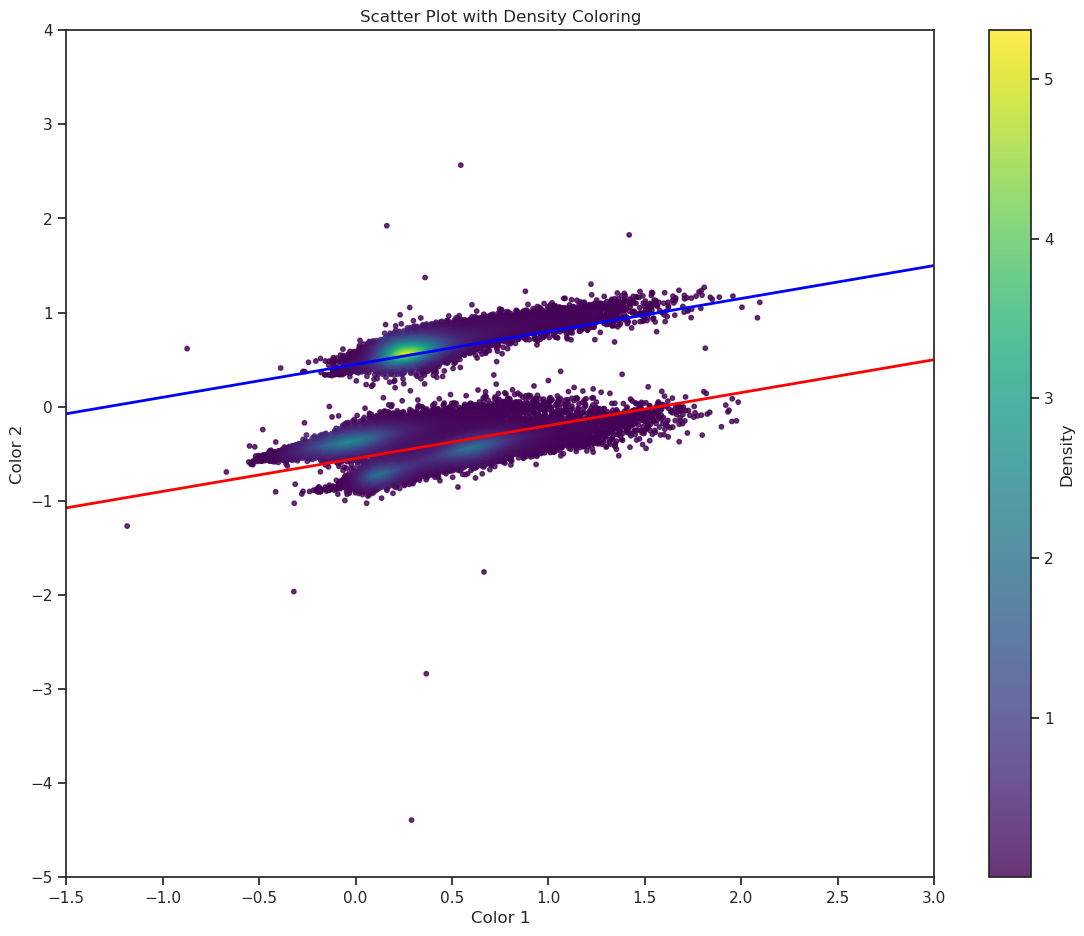

In [17]:
plots(ri, rj660, x_values, y_values, y_values1, xlim=(-1.5, 3), ylim=(-5, 4), sample_size=100000)

In [18]:
# Select objects below the line
# below_line = rj660 < equation(ri)
color_crit = (rj660  <= 0.35*ri - 0.55)

# upper_line = rj660 < equation(ri)
color_crit_upper = (rj660 >= 0.35*ri + 0.45)

In [19]:
tab_clean_below = tab_clean[color_crit]
len(tab_clean_below)

73046

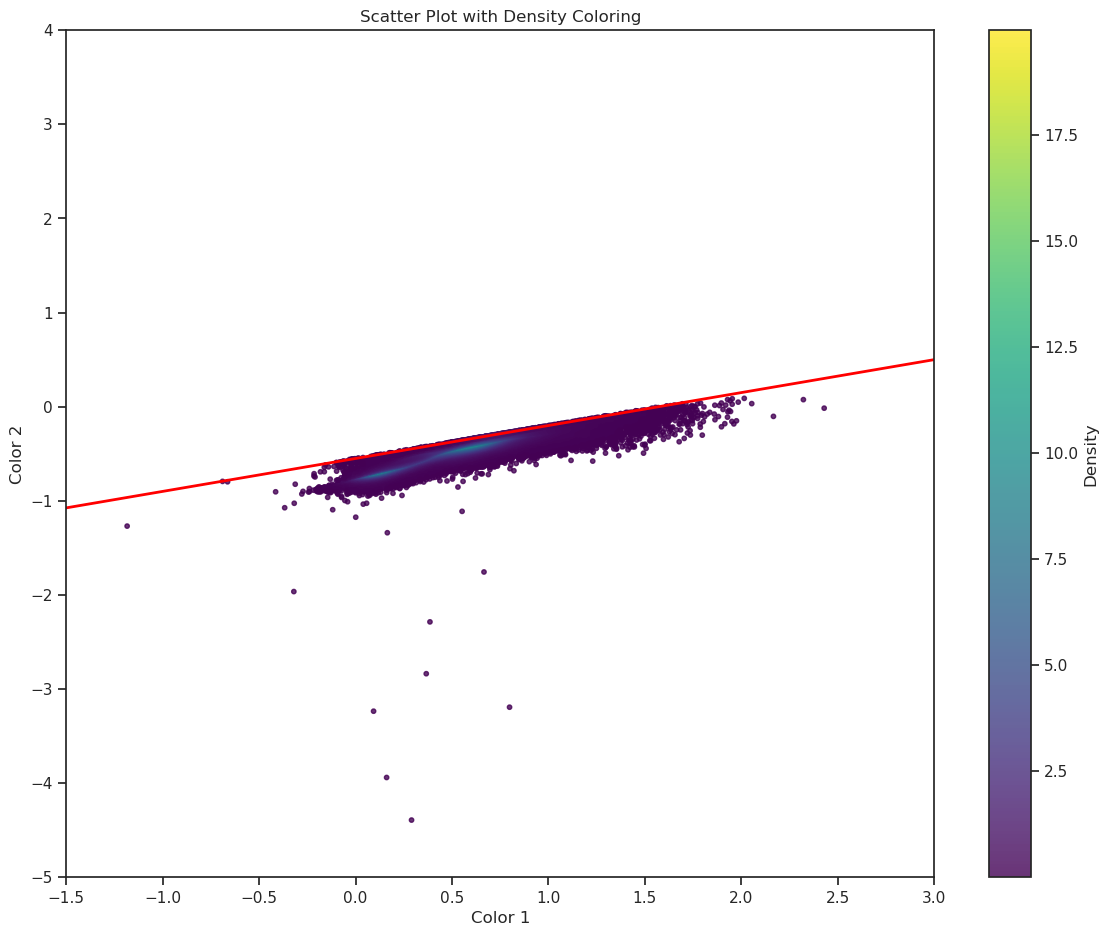

In [20]:

ri_below = tab_clean_below["r"] - tab_clean_below["i"]
rj660_below = tab_clean_below["r"] - tab_clean_below["F660"]



plots(ri_below, rj660_below, x_values, y_values, xlim=(-1.5, 3), ylim=(-5, 4))

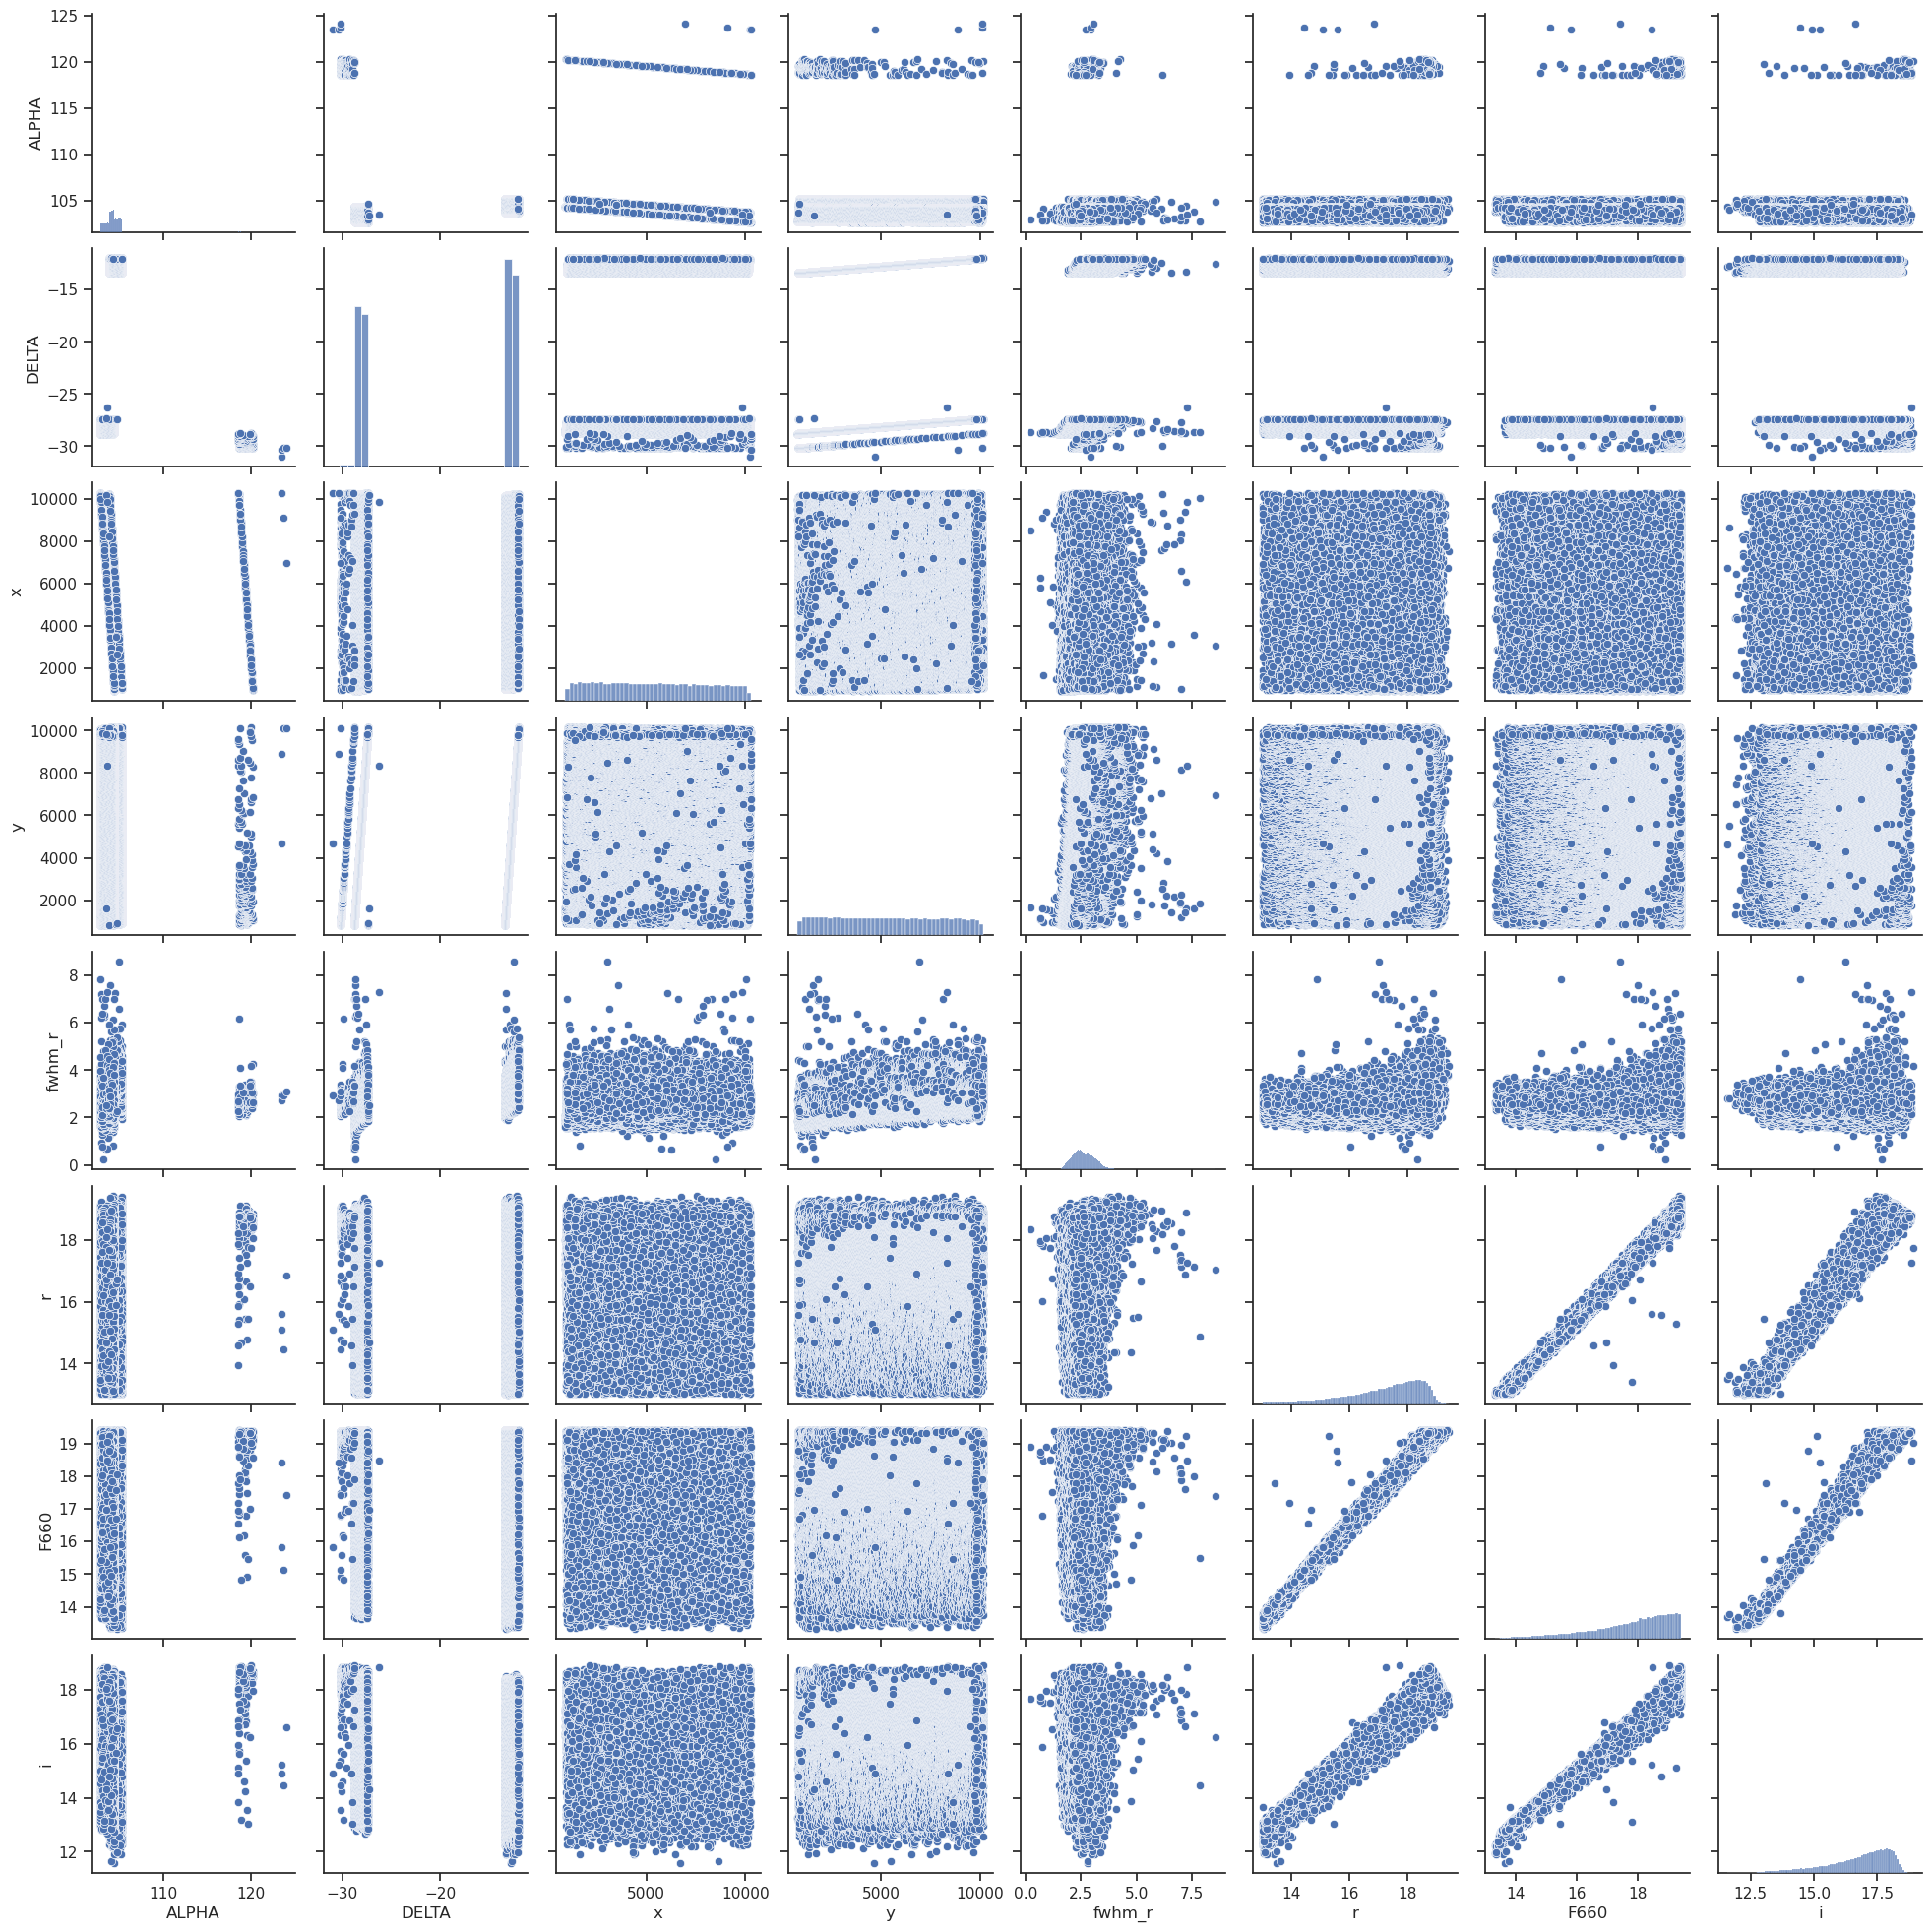

In [21]:
df_bellow = tab_clean_below.to_pandas()
#Select columns 
df_bellow_ = df_bellow[["ALPHA", "DELTA", "x", "y", "fwhm_r", "r", "F660", "i"]]
             
sns.pairplot(df_bellow_)

In [22]:
xx_values = np.linspace(100000, 10, 11000) 
yy = equation(444, -4510000, xx_values)
yyy = equation(-0.01, 10100, xx_values)
yyyy = equation(-0.013, 1050, xx_values)

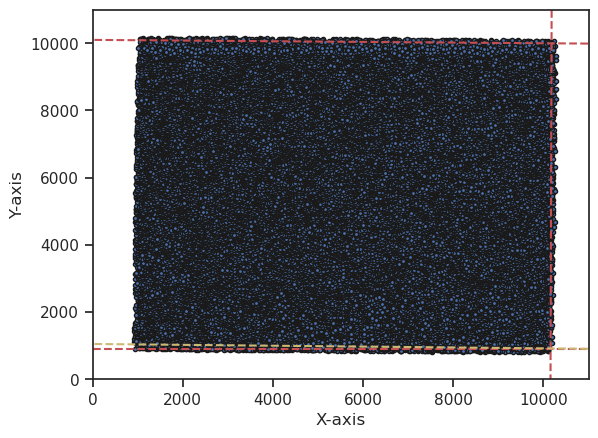

In [23]:
# Dropped the border
# Create a plot
plt.scatter(df_bellow["x"], df_bellow['y'], marker=".", edgecolors="k")
# Add horizontal line at y=0
#plt.axhline(y=10000, color='r', linestyle='--')
plt.axhline(y=900, color='r', linestyle='--')
plt.plot(xx_values, yyy, color='r',linestyle='--')
# Add vertical line at x=0
#plt.axvline(x=10000, color='g', linestyle='--')
plt.plot(xx_values, yy, color='r',linestyle='--')
plt.plot(xx_values, yyyy, color='y',linestyle='--')
# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(0, 11000)
plt.ylim(0, 11000)
# Show the plot
plt.show()

## Clean border

In [24]:
# Now dropping the borders
#yy = equation(444, -4510000, xx_values)
#yyy = equation(-0.01, 10100, xx_values)
border_crit = (tab_clean["y"]  >= 444*tab_clean["x"] - 4510000) & \
               (tab_clean["y"]  <= -0.01*tab_clean["x"] + 10100) & \
            (tab_clean["y"] <= 80*tab_clean["x"] - 86000) &  (tab_clean["y"] >= -0.013*tab_clean["x"] + 1050)

In [25]:
tab_clean_border = tab_clean[border_crit]
tab_clean_border

NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,ierr,z,zerr,F378,F378err,F395,F395err,F410,F410err,F430,F430err,F515,F515err,F660,F660err,F861,F861err,flags_i,fwhm_i,fwhm_psf_i,ellog_i,ellip_i,class_i,spread_i,flux_radius_i,area_i,mumax_i,mag_aper2_i,magerr_apper2_i,mag_aper4_i,magerr_apper4_i,mag_aper6_i,magerr_apper6_i,flux_aper6_u,fluxerr_aper6_u,flux_aper6_g,fluxerr_aper6_g,flux_aper6_r,fluxerr_aper6_r,flux_aper6_i,fluxerr_aper6_i,flux_aper6_z,fluxerr_aper6_z,flux_aper6_F378,fluxerr_aper6_F378,flux_aper6_F395,fluxerr_aper6_F395,flux_aper6_F410,fluxerr_aper6_F410,flux_aper6_F430,fluxerr_aper6_F430,flux_aper6_F515,fluxerr_aper6_F515,flux_aper6_F660,fluxerr_aper6_F660,flux_aper6_F861,fluxerr_aper6_F861,x,y,field,a_image,b_image,theta_image,kron_radius_i,flags_r,fwhm_r,fwhm_psf_r,ellog_r,ellip_r,class_r,spread_r,flux_radius_r,area_r,mumax_r,kron_radius_r
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,int16,float64,float32,float64,float64,float64,float64,float64,int16,float64,float64
1019,103.80510745986123,-13.41386579008144,20.372166,0.3852084,18.672583,0.03704234,17.197174,0.01650126,16.605507,0.01532726,17.001217,0.013330903,19.891586,0.22321187,17.555674,0.076543525,18.621517,0.10242278,19.076572,0.12824439,17.847641,0.063508555,17.6423,0.018711142,17.068338,0.019014915,0,2.308101,1.42,1.1801049,0.1526177,0.98118377,0.0031936127,1.3136721,34,17.318005,16.828247,0.017138518,16.685743,0.024286982,16.706026,0.034823786,0.5473639,0.3947541,46.58764,4.1508408,95.26439,3.37822,105.09682,3.3700454,77.5594,2.1303706,-0.73858565,0.29705378,4.376949,0.4373096,5.4019446,1.1338425,4.611925,1.1738474,7.8826056,1.2132087,8.536708,0.3919901,25.691729,0.99448615,10028.05,925.88806,d049,1.3934906,1.1808193,31.12383,3.5,0,2.4118307,1.56,1.1801049,0.1526177,0.97959024,0.0040506315,1.324877,30,17.944036,3.5
1033,103.84786613136102,-13.413839826666099,99.0,99.0,19.472372,0.07071483,17.686386,0.02307624,16.941145,0.019034142,17.32015,0.016378438,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,18.846651,0.14274307,17.978096,0.023713244,17.392513,0.023223603,0,2.1895964,1.42,1.1618295,0.13928854,0.9821516,0.0023006722,1.2489992,31,17.791409,17.167467,0.021803694,16.985704,0.031182934,16.975882,0.044122327,-0.36225423,0.39359725,11.246774,4.104815,50.187088,3.3189962,81.96852,3.330241,55.635754,2.0977201,0.2287282,0.2975917,-0.86395955,0.42221096,0.18508995,1.119917,0.07698067,1.1617457,3.3414705,1.2022213,7.2801275,0.38997483,17.937534,0.97718185,9755.754,926.8184,d049,1.3559483,1.1670803,37.23569,0.0,0,2.443392,1.56,1.1618295,0.13928854,0.99872595,0.0041613113,1.2477572,25,18.65463,3.5
1062,103.80007903272964,-13.414134638181848,20.570696,0.4738764,19.858276,0.09616482,18.491512,0.041761227,17.802423,0.034523137,18.230528,0.03052177,99.0,99.0,18.869808,0.20575166,99.0,99.0,99.0,99.0,18.95795,0.1820549,19.022053,0.051372338,18.332003,0.043959327,0,2.1796372,1.42,1.2189057,0.17959195,0.98897624,-3.2567517e-05,1.2390361,21,18.471556,18.066893,0.043894123,18.065466,0.079629414,18.102425,0.12118331,0.7315116,0.3952347,18.809374,4.1167393,25.665644,3.288515,29.042248,3.240733,24.034449,2.0515025,0.35462525,0.29808864,2.1436398,0.42985228,2.4910922,1.12659,-0.6748048,1.1621828,4.3321223,1.2052172,3.531625,0.38436815,8.003112,0.9553367,10060.067,924.0354,d049,1.2506485,1.0260421,28.928776,3.5,0,2.216275,1.56,1.2189057,0.17959195,0.94639546,0.005387284,1.2993295,16,19.164576,3.5
1088,103.98478943618059,-13.405154792614775,15.445342,0.00906218

## Spliting by r bin

In [27]:
# Define conditions for splitting the table based on the "r" column
condition_1 = tab_clean_border['r'] <= 16
condition_2 = (tab_clean_border['r'] > 16) & (tab_clean_border['r'] <= 17.5)
condition_3 = (tab_clean_border['r'] > 17.5) & (tab_clean_border['r'] <= 18.5)
condition_4 = (tab_clean_border['r'] > 18.5) & (tab_clean_border['r'] <= 19.5)

# Apply conditions to filter the table
table_1 = tab_clean_border[condition_1]
table_2 = tab_clean_border[condition_2]
table_3 = tab_clean_border[condition_3]
table_4 = tab_clean_border[condition_4]

In [28]:
len(table_1)

39991

In [30]:
# Convert Astropy tables to pandas DataFrames and save each one
df_table_1 = table_1.to_pandas()
df_table_1.to_csv('../Disk_Lomeli_problematicFields/disk_splus_13r16.csv', index=False)
del df_table_1  # Free memory by deleting the DataFrame

In [31]:
df_table_2 = table_2.to_pandas()
df_table_2.to_csv('../Disk_Lomeli_problematicFields/disk_splus_16r175.csv', index=False)
del df_table_2

In [32]:
df_table_3 = table_3.to_pandas()
df_table_3.to_csv('../Disk_Lomeli_problematicFields/disk_splus_175r185.csv', index=False)
del df_table_3

In [33]:
df_table_4 = table_4.to_pandas()
df_table_4.to_csv('../Disk_Lomeli_problematicFields/disk_splus_185r195.csv', index=False)
del df_table_4